# Reports
1. Inputs: data with feature engineering 
2. Outputs: prepared data to ml modeling
3. ...

# 1.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from xgboost import XGBRFClassifier

from boruta import BorutaPy

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import pickle

import time
import warnings

# Tempo de processamento
time_agora = time.time()

D:\My Drive\Pessoal\Projetos\environments\data_science\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 1.1 Colecting data

In [2]:
df = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\exportings\\df_to_data_preparation.pkl', 'rb'))

# 6.0 Data Preparation

### 6.1 Preprocessing

In [3]:
# backup
df_ = df.copy()

In [4]:
# backup
df = df_.copy()

# Feature dummies
temp = pd.get_dummies(df['Vehicle_Age_'], prefix='Vehicle_Age')
temp.drop('Vehicle_Age_0', axis=1, inplace=True)
df = pd.concat([df, temp], axis=1)

# Removendo features que não seguirão para modelagem
features_remover = ['id', 'Gender', 'Vehicle_Age', 'Vehicle_Age_', 'Vehicle_Damage', 'Policy_Sales_Channel', 
                    'Region_Code', 'Vintage', 'Annual_Premium']
df.drop(features_remover, axis=1, inplace=True)
model_columns = df.drop('Response', axis=1).columns.to_list()
print(model_columns)

# target
target = ['Response']

# Split X and y
X = df.drop(target, axis=1)
X = np.array(X)
y = df[target]
y = np.array(y).reshape(1, len(y))[0]

# Split train end test
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Split train_ end valid
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.3, random_state=101)

# Standard Scaler fit
scaler = StandardScaler().fit(X_train)

# Scaler transform
X = scaler.transform(X)
X_ = scaler.transform(X_)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

# Resolvendo desbalanceamento
# Nearmiss
near = NearMiss()
X_near, y_near = near.fit_resample(X_, y_)
X_train_near, y_train_near = near.fit_resample(X_train, y_train)

# Smote
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_, y_)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

['Age', 'Driving_License', 'Previously_Insured', 'Gender_', 'Vehicle_Damage_', 'Policy_Sales_Channel_Response_Mean', 'Region_Code_Response_Mean', 'High_Age', 'Log_Annual_Premium', 'Vehicle_Age_1', 'Vehicle_Age_2']


### 6.2 Feature Selection

##### 6.2.1 Principais Insights:
1. As features com maior relevância identificadas através de Exploração de Dados foram: Vehicle_Damage, Previously_Insured, Vehicle_Age, Policy_Sales_Channels_Response_Mean, Age
2. 6 Dimensões compõem 95% de toda a variabilidade das features.
3. A feature Driving_License não agrega ao modelo

##### 6.2.2 Por Correlação

In [5]:
correlations = abs(df.corr()['Response'].drop('Response', axis=0))
correlations
ranking = pd.DataFrame()
ranking['correlations'] = correlations

##### 6.2.3 RFE (Ranking por eliminação recursiva)

In [6]:
# model description
xgbrf_model = XGBRFClassifier(use_label_encoder=False, eval_metric='error')

# rfe description
rfe_model = RFE(xgbrf_model)

# fiting model
rfe_fit = rfe_model.fit(X_train_near, y_train_near)

# ranking
ranking['rfe_xgb'] = rfe_fit.ranking_
print(rfe_fit.ranking_)
ranking.sort_values('rfe_xgb').index.to_list()

[1 7 6 4 3 1 1 1 2 5 1]


['Age',
 'Policy_Sales_Channel_Response_Mean',
 'Region_Code_Response_Mean',
 'High_Age',
 'Vehicle_Age_2',
 'Log_Annual_Premium',
 'Vehicle_Damage_',
 'Gender_',
 'Vehicle_Age_1',
 'Previously_Insured',
 'Driving_License']

Alta preferência por features numéricas, não confere com a exploração de dados, possivelmente overfitado.

##### 6.2.4 Importances

###### 6.2.4.1 Random Forest

In [7]:
# model definition
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1000, random_state=101)

# fiting model
rf_fit = rf_model.fit(X_train_smote, y_train_smote)

# preditions
rf_predict = rf_fit.predict(X_valid)
ranking['importance_rf'] = rf_model.feature_importances_

# metrics
print(classification_report(y_valid, rf_predict))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80     72267
           1       0.28      0.93      0.43     10053

    accuracy                           0.70     82320
   macro avg       0.63      0.80      0.61     82320
weighted avg       0.90      0.70      0.75     82320



###### 6.2.4.2 XGRFBoost

In [8]:
# fiting model
xgbrf_fit = xgbrf_model.fit(X_train_smote, y_train_smote)

# predictions
xgbrf_predict = xgbrf_fit.predict(X_valid)
ranking['importance_xgb'] = xgbrf_model.feature_importances_

# metrics
print(classification_report(y_valid, xgbrf_predict))

              precision    recall  f1-score   support

           0       0.99      0.65      0.78     72267
           1       0.27      0.94      0.42     10053

    accuracy                           0.68     82320
   macro avg       0.63      0.79      0.60     82320
weighted avg       0.90      0.68      0.74     82320



##### 6.2.5 Boruta

In [9]:
# model descrition
boruta_model = BorutaPy(xgbrf_model, random_state=101)

# fiting model
boruta_fit = boruta_model.fit(X_train_near, y_train_near)

# ranking features
ranking['boruta'] = boruta_fit.ranking_
print(boruta_fit.ranking_)
ranking.sort_values('boruta', ascending=False).index.to_list()

[1 2 1 1 1 1 1 1 1 1 1]


['Driving_License',
 'Age',
 'Previously_Insured',
 'Gender_',
 'Vehicle_Damage_',
 'Policy_Sales_Channel_Response_Mean',
 'Region_Code_Response_Mean',
 'High_Age',
 'Log_Annual_Premium',
 'Vehicle_Age_1',
 'Vehicle_Age_2']

In [10]:
# ranking_boruta = [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# ranking['boruta'] = ranking_boruta

##### 6.2.6 Comparison

In [11]:
ranking

,correlations,rfe_xgb,importance_rf,importance_xgb,boruta
Age,0.111110,1,0.087400,0.010189,1
Driving_License,0.010160,7,0.000000,0.002124,2
Previously_Insured,0.341668,6,0.367064,0.194540,1
Gender_,0.052551,4,0.001333,0.000626,1
Vehicle_Damage_,0.355045,3,0.352856,0.755569,1
Policy_Sales_Channel_Response_Mean,0.263692,1,0.108636,0.018986,1
Region_Code_Response_Mean,0.138005,1,0.013888,0.001515,1
High_Age,0.206226,1,0.024389,0.008963,1
Log_Annual_Premium,0.002207,2,0.002371,0.000216,1
Vehicle_Age_1,0.209722,5,0.039517,0.004763,1


1. As colunas "correlations", "importance_rf" e "importance_xgb" são quantitativas e estão na mesma escala
2. A coluna "rfe_xgb" é tipo tipo ranking, quanto menor o número melhor a colocação
3. A coluna "boruta" é binária, 1 significa uma feature relevante e 2 uma feature a ser dispensada

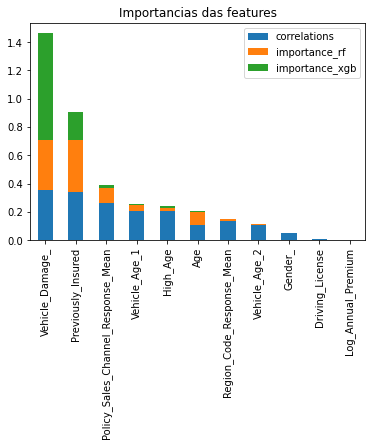

In [12]:
ranking_1 = ranking[['correlations', 'importance_rf', 'importance_xgb']].copy()
ranking_1['total'] = np.sum(ranking_1, axis=1)

ranking_1.sort_values('total', ascending=False, inplace=True)

ranking_1.drop('total', axis=1).plot(kind='bar', stacked=True)
plt.title('Importancias das features');

##### 6.2.7 Removing expendable features

In [13]:
X = np.delete(X, 1, 1)
X_train = np.delete(X_train, 1, 1)
X_valid = np.delete(X_valid, 1, 1)
X_test = np.delete(X_test, 1, 1)
X_smote = np.delete(X_smote, 1, 1)
X_near = np.delete(X_near, 1, 1)
X_train_smote = np.delete(X_train_smote, 1, 1)
X_train_near = np.delete(X_train_near, 1, 1)

model_columns.pop(1)

'Driving_License'

# 7.0 Exporting data

###### 7.1 Scaler

In [14]:
pickle.dump(scaler, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\webapp\\scaler_standard_scaler.pkl', 'wb'))

###### 7.2 Arrays

In [15]:
X_to_modeling = [X_valid, X_test, X]
X_imb_to_modeling = [X_smote, X_near, X_train_smote, X_train_near]
y_to_modeling = [y_smote, y_near, y_train_smote, y_train_near, y_valid, y_test, y]
pickle.dump(X_to_modeling, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\exportings\\X_to_modeling.pkl', 'wb'))
pickle.dump(X_imb_to_modeling, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\exportings\\X_imb_to_modeling.pkl', 'wb'))
pickle.dump(y_to_modeling, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\exportings\\y_to_modeling.pkl', 'wb'))

###### 7.4 Columns

In [16]:
pickle.dump(model_columns, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\exportings\\model_columns.pkl', 'wb'))

###### 7.5 Ranking of features

In [17]:
pickle.dump(ranking, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\exportings\\ranking_feature_selection.pkl', 'wb'))

###### 7.5 Expendable features

In [18]:
pickle.dump(features_remover, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\webapp\\_features_remover.pkl', 'wb'))

# Time

In [19]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-time_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 6 minutos
